In [2]:
pip install pybbn


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40441 sha256=99300b781e04021139f1a5765a38ec0d7d5174e478458a24d9ddc391eeb188de
  Stored in directory: c:\users\sowmi\appdata\local\pip\cache\wheels\07\00\f6\a1ad0aa73a832ed29ae62a32a5bd05a911596be0d8d7cc7ad6
Successfully built pybbn
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd # for data manipulation
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
#Set Pandas options to display more columns
pd.options.display.max_columns=50

In [4]:
df=pd.read_csv('weatherAUS.csv',encoding='utf-8')
print(df)

              Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0            NaN           W           44.0          W        WNW 

In [6]:
df=df[pd.isnull(df['RainTomorrow'])==False]

In [8]:
#df=df.fillna(df.mean())
# Fill missing values with the mean of numeric columns
numeric_columns = df.select_dtypes(include='number').columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

In [9]:
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

In [10]:
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob

In [11]:
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

join_tree = InferenceController.apply(bbn)
pos={0: (-1,0), 1: (-1, 0.5), 2: (1, 0), 3:(0,-0.5)}

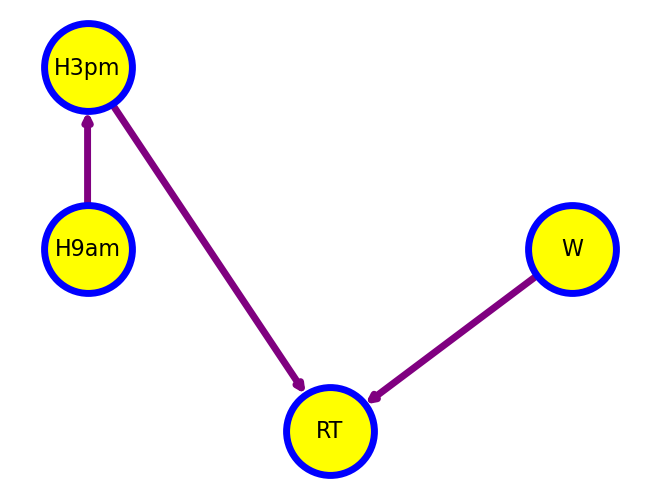

In [16]:
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "yellow",
    "edgecolors": "blue",
    "edge_color": "purple",
    "linewidths": 5,
    "width": 5,}

n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()